# Cluster Analysis of Tweets
## Cluster Analysis Details
Here we are trying to uncover some underlying structure to the tweets we have collected so far. We will first try to perform a cluster analysis to the tweets to see if the tweets will group into clusters that we can exploit when trying to label data. We start by describing the problem:

We are given an input dataset $\mathbf{X} = [x_1, \dots, x_k]$, where $x_i \in \mathbb{R}^d$. We want to find a dictionary $\mathbf{D} \in \mathbb{R}^{d x n}$: $\mathbf{D} = [d_1, \dots, d_n]$ and a representation $\mathbf{R} = [r_1, ..., r_k], r_i \in \mathbb{R}^n$ s.t. both $||\mathbf{X} - \mathbf{DR}||^2_F$ is minimized and the representations $r_i$ are sparse enough. This has the optimization problem:

${argmin}_{D\in C, r_i \in \mathbb{R}^n} \sum_{i=1}^{k} ||x_i - Dr_i||^2_2 + \lambda ||r_i||_0$, where $C \equiv \{D\in \mathbb{R}^{d x n}: ||d_i||_2 \leq 1, \forall i \in 1, \dots, n\}, \lambda >0$

$C$ is required to constrain $\mathbf{D}$ so that its atoms would not reach arbitrarily high values allowing for arbitrarily low (but non-zero) values of $r_{i}$. $\lambda$  controls the trade off between the sparsity and the minimization error. We usually use the $\ell_1$ instead of the $\ell_0$ norm instead in order to maintain convexity of the problem. In this case, we are dealing with an __overcomplete dictionary__ since the dimension of the representations of the strings $n$ is larger than the input data's dimension $d$. An overcomplete dictionary which allows for sparse representation of signal can be a famous transform matrix (wavelets transform, fourier transform) or it can be formulated so that its elements are changed in such a way that it sparsely represents the given signal in a best way. Learned dictionaries are capable of giving sparser solutions as compared to predefined transform matrices.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import glob
import string
import matplotlib.pyplot as plt
import matplotlib as mpl

nltk.download('punkt')
nltk.download('twitter_samples')

[nltk_data] Downloading package punkt to /home/henryfbp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/henryfbp/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [2]:
# NLTK tweets
from nltk.corpus import twitter_samples

tweets = twitter_samples.tokenized()
tweet_dict = []
for i in range(len(tweets)):
    for j in range(len(tweets[i])):
        tweet_dict.append(tweets[i][j])

In [3]:
# Making a list directory of all the tweets we have collected
files_0 = glob.glob('./datasets/water_tweets/gathered_water/*.csv')
water1_tweets = pd.read_csv('./datasets/water_tweets/water1.csv', encoding = 'ISO-8859-1', delimiter = ',')

# loading JSON files
from pandas.io.json import json_normalize
with open('datasets/water_tweets/gathered_water/water8.json', 'r', encoding="utf-8") as json_file:
    water_json_1 = pd.read_json('datasets/water_tweets/gathered_water/water8.json', typ='object', orient='columns')
    water_json_1 = pd.io.json.json_normalize(water_json_1)
    water_json_1 = water_json_1[['text', 'timestamp']]

with open('datasets/water_tweets/gathered_water/water9_drought.json', 'r', encoding = 'utf-8') as json_file:
    water_json_2 = pd.read_json('datasets/water_tweets/gathered_water/water9_drought.json', typ='object', orient='columns')
    water_json_2 = pd.io.json.json_normalize(water_json_2)
    water_json_2 = water_json_2[['text', 'timestamp']]

water_jsons = pd.concat([water_json_1, water_json_2])
water_jsons.columns = ['text', 'date']
water_jsons['retweet_count'] = np.nan
water_jsons['category'] = np.nan
water_jsons['tweet_id'] = np.nan
water_jsons = water_jsons[['category', 'date', 'text', 'retweet_count', 'tweet_id']]

# Loading uniformly formatted pulled tweets
water_csvs = pd.concat([pd.read_csv(f, encoding = 'ISO-8859-1', delimiter = ';') for f in files_0])
water_csvs = pd.concat([water1_tweets, water_csvs, water_jsons])
water_csvs = water_csvs[['category', 'date', 'text', 'retweet_count', 'tweet_id']]
water_csvs = water_csvs[water_csvs['text'] != 'text']
water_csvs = water_csvs[water_csvs['category'] != 'pcb']
water_csvs = water_csvs[water_csvs['category'] != 'benzene']
files_1 = glob.glob('./datasets/water_tweets/rnd_tweets/*.csv')
rnd_csvs = pd.concat([pd.read_csv(f, encoding = 'ISO-8859-1', delimiter = ';') for f in files_1])
rnd_csvs = rnd_csvs[['category', 'date', 'text', 'retweet_count', 'tweet_id']]
rnd_csvs = rnd_csvs[rnd_csvs['text'] != 'text']
all_csvs = pd.concat([water_csvs, rnd_csvs])
all_csvs['text'] =  all_csvs['text'].astype(str)
all_csvs = all_csvs.drop_duplicates(subset = ['text'], keep = 'first').reset_index()
all_csvs = all_csvs.iloc[:, 1:]
#all_csvs.columns = ['category', 'date', 'tweet', 'retweet_count', 'tweet_id']
print(len(all_csvs))

all_csvs.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



419569


,category,date,text,retweet_count,tweet_id
0,flash flood,6/25/2019 20:45,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,0.0,1.140000e+18
1,flash flood,6/25/2019 20:28,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,0.0,1.140000e+18
2,flash flood,6/25/2019 20:21,So the maintenance men at my apartment complex...,0.0,1.140000e+18
3,flash flood,6/25/2019 20:07,".@NWStulsa issued 1,530 flood/flash flood prod...",0.0,1.140000e+18
4,flash flood,6/25/2019 19:55,"They might not call it a #climatedebate, but c...",0.0,1.140000e+18


In [4]:
tweet_text = list(all_csvs.text.astype(str))

# Tokenizing the tweet words
for i in range(len(tweet_text)):
    tweet = tweet_text[i]
    tweet = tweet.translate(str.maketrans('','', string.punctuation))
    tweet = tweet.split()
    for j in range(len(tweet)):
        new_word = tweet[j]
        tweet_dict.append(new_word)
print(len(tweet_dict))

new_tweet_dict = []
for i in range(len(tweet_dict)):
    word = tweet_dict[i]
    word = word.translate(str.maketrans('', '', string.punctuation))
    word = word.lower()
    new_tweet_dict.append(word)
new_tweet_dict[786085:786110]

11092120


['the',
 'bath',
 'all',
 'taps',
 'have',
 'isolation',
 'valves',
 'except',
 'the',
 'leaky',
 'bath',
 '12',
 'httpstcouc3aoh0iwe',
 'sweatienext',
 'he',
 'did',
 'come',
 'by',
 'today',
 'amp',
 'check',
 'the',
 'ceiling',
 'no',
 'nest']

## Build a Dictionary

In [5]:
from collections import Counter

vocabulary_size = 50000

# UNK = unknown words, HST = hashtag, EMT = emoticon, URL is self-explanatory, THDL = Twitter handle
vocabulary = [("<UNK>", None)] + [("<HST>", None)] + [("<EMT>", None)] + [("<URL>", None)] + [("<THDL>", None)] +\
            Counter(new_tweet_dict).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in new_tweet_dict])
print(len(vocabulary))
#print(len(data))

50004


## Algorithm Used: K-means
Using the vector representations of the tweets we have gathered, we can perform k-means clustering of the tweets we have gathered. We will perform tf-idf vectorization of the tweets to aid the clustering algorithm, which calculates how often a word appears in a tweet and then counts its inverse document frequency to standardize the count. The standard k-means in this case is carried out as follows:

Given an initial-set of *k* means $m_1^{(1)}, \dots, m_k^{(1)}$, we alternate between:

__Assignment step:__ Assign each observation to the cluster whose mean has the least squared Euclidean distance, this is intuitively the "nearest" mean. (Mathematically, this means partitioning the observations according to the Voronoi diagram generated by the means).

$S_i^{(t)} = \{x_p: ||x_p - m_i^{(t)}||^2 \leq ||x_p - m_j^{(t)}||^2, \forall j \in 1, \dots, k\}$, where each $x_p$ is assigned to one $S^{(t)}$, even it can be assigned to two or more of them.

__Update step:__ Calculate the new means (centroids) of the observations of the new clusters:

$m_i^{(t+1)} = \frac{1}{|S_i^{(t)}|}\sum_{x_j \in S_i^{(t)}} x_j$

The algorithm has converged when the assignments no longer change. The algorithm does not guarantee to find the optimum.

In [6]:
# tf-idf vectorization
all_tweets = np.array(all_csvs.text)
water_csvs = water_csvs.drop_duplicates(subset = ['text'], keep = 'first')
water_tweets = np.array(water_csvs.text)

# If we get labeled data, we would use train_test_split to test out our model
#from sklearn.model_selection import train_test_split
#X_train, X_test = train_test_split(water_tweets, test_size = 0.20, random_state = 42)

from sklearn.feature_extraction.text import TfidfVectorizer
# We use the vocabulary formulation from the embedding formed from the autoenconder_for_tweets.ipynb
vectorizer = TfidfVectorizer(strip_accents = 'unicode', stop_words = 'english', vocabulary = vocabulary)

# tf-idf vectorization of the training set
X_tfidf = vectorizer.fit_transform(water_tweets)
#print(vectorizer.get_feature_names())
print(X_tfidf.shape)

(99205, 50004)


In [7]:
# Clustering of water tweets
from sklearn import cluster
from sklearn import metrics

print(type(X_tfidf))
print(water_tweets[:5])
print(X_tfidf[:5])

<class 'scipy.sparse.csr.csr_matrix'>
["@LeslieWalden6 @MookieTheBrave @AngusMcPussPuss @AngelaStillwell @cat_samson @arkantart @Biscuit_Meow @duchess_meow @TobiasandJasper @goodman_carina It's cwazy!! Mom tiwed of seeing flash flood warnings fwom The Weather Channel pop up on her phone evewyday. She appweciates the warning, but she knows which aweas are pwone to flooding.ð\x9f\x98¼ð\x9f\x98¼"
 '4 PASSES to FLASH FLOOD WATER PARK in Battle Creek, MICHIGAN - 2019 season!!! $12.00 | #WaterparkTickets | https://t.co/tIumVg5T0d Grab Your Tickets https://t.co/UQNz5zZ7vC'
 'So the maintenance men at my apartment complex are leaf blowing during a flash flood warning... https://t.co/YkWkVzTvSy'
 '.@NWStulsa issued 1,530 flood/flash flood products in May 2019 alone!  Includes new warnings/advisories + all follow up statements #okwx #arwx https://t.co/3M9GfJyuez'
 'They might not call it a #climatedebate, but considering that the venue where 20 Democrats are meeting in Miami this week was once i

Fit 25 clusters
Fit 50 clusters
91772.51344970112 [50]


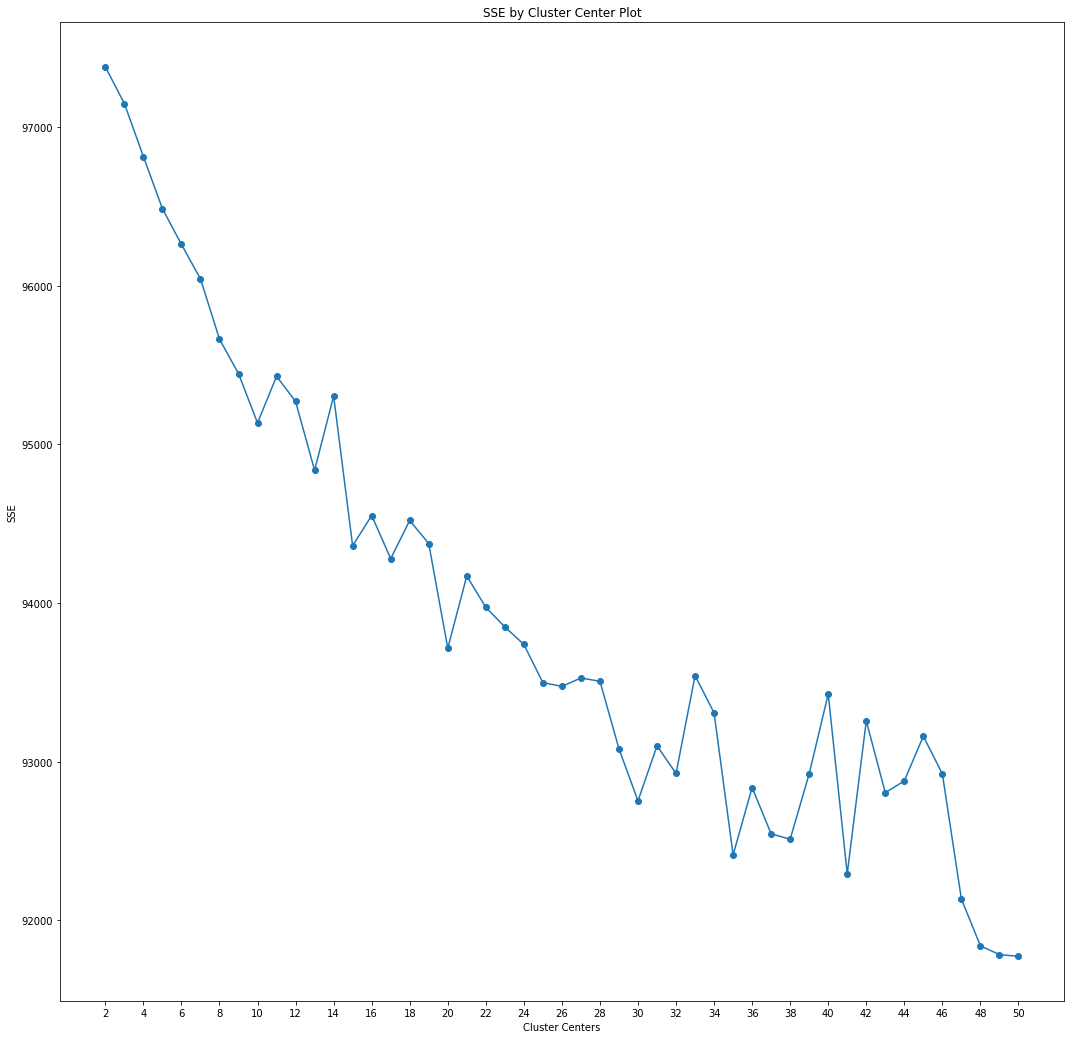

In [8]:
# Cluster analysis 
def find_optimal_clusters(data, min_k, max_k, num):
    iters = np.linspace(min_k, max_k, num = num).astype(int)
    
    sse = []
    for k in range(len(iters)):
        sse.append(cluster.MiniBatchKMeans(n_clusters = iters[k], init_size = 1024, batch_size = 2048, random_state = 42,
                                          reassignment_ratio = 0.01).fit(data).inertia_)
        if iters[k] % 25 == 0:
            print('Fit {} clusters'.format(iters[k].astype(int)))
            
    idx = np.where(sse == np.amin(sse))
    print(np.amin(sse), iters[idx])
          
    f, ax = plt.subplots(1, 1, figsize = (18, 18))
    #for n, label in enumerate(ax.xaxis.get_ticklabels()):
      #  if n % 10 != 0:
     #       label.set_visible(False)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters[np.where(iters % 2 == 0)])
    ax.set_xticklabels(iters[np.where(iters % 2 == 0)])
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_tfidf, 2, 50, 49)

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [10]:
# *Almost* the best amount of clusters given the elbow function
# evaluation shown above using mini-batch k-means
clusters = cluster.MiniBatchKMeans(n_clusters=15, init_size=1024, batch_size=2048, random_state=42).fit_predict(X_tfidf)

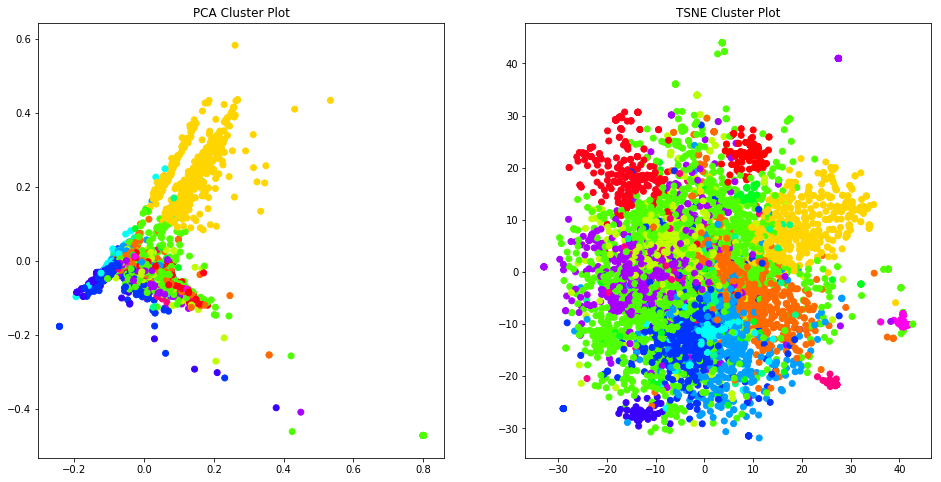

In [11]:
# Plotting the cluster analysis of gathered water tweets
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=10000, replace=False)
    
    pca = PCA(n_components=0.95).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=0.95).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=5000, replace=False)
    label_subset = labels[max_items]
    label_subset = [mpl.cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X_tfidf, clusters)

Functions are similar to the ones found from Kaggle at this link: https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans/comments

In [12]:
#This code is currently in markdown as it takes up way to much memory to show these results.

# What are the most common keywords in these clusters
# Takes up too much memory
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X_tfidf, clusters, vectorizer.get_feature_names(), 15)



Cluster 0
closed,harmful,gulf,blue,largest,green,coast,erie,mississippi,beaches,https,toxic,lake,bloom,algae

Cluster 1
amp,just,years,http,thought,farmers,like,end,love,ita,year,rain,climate,https,drought

Cluster 2
july,00,nws,jul,edt,county,till,issued,cdt,pm,watch,https,warning,flash,flood

Cluster 3
better,conservation,project,sustainable,poor,resource,new,need,india,waste,resources,amp,https,water,management

Cluster 4
people,pipe,just,ecoli,plastic,coli,sewage,wastewater,bacteria,amp,contamination,waste,lead,water,https

Cluster 5
2013,nashua,know,rutherford,going,waste,just,world,people,went,https,water,spill,chemical,like

Cluster 6
flash,like,ita,extreme,humidity,summer,amp,hot,drought,drinking,wave,dry,water,https,heat

Cluster 7
really,https,eating,dona,day,dry,like,just,drought,ll,ita,water,ve,drinking,ia

Cluster 8
time,day,really,hair,amp,good,ita,skin,like,know,run,runs,just,https,dry

Cluster 9
ita,today,good,need,people,safe,eating,clean,drink,day,just,like,https,wat

__Conclusion:__

We will not consider this a wash until we are able to thread these calculations through a GPU or have access to a server with a larger memory. At this point, the clustering of these tweets do not appear to produce any meaningful separations that are useful to us considering there are just so many clusters. It seems possible that there needs to be more clusters as at our "elbow" of 17 clusters, the overall trend appears that the SSE-criterion will continue to decrease as we increase the number of clusters. Everything appears to be in a "free for all" by looking at out plots with a few minor exceptions. We need to label the clusters in the plots and figure out which keywords from our tf-idf vectorization are most associated with the clusters.